In [1]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2
import numpy as np

from src.GridWorldMDP.objectworld_utils import draw_path, generate_demonstrations, init_object_world, visitation_frequency
from src.deepmaxent_irl_objectworld import run_deepmaxent_irl
from src.maxent_irl_objectworld import run_maxent_irl
from src.img_utils import Visualizer, get_evd, draw_evd
from src.argument_parser import get_parser, parse_args_str

PARSER = get_parser()

In [8]:
np.random.seed(1)
BASIC_ARGS = """
--exp_name test
--n_objects 15
--n_colours 2
--height 8
--width 8
--seed 2
--n_trajs 10
--n_query 1
--device cpu
"""
args = parse_args_str(PARSER, BASIC_ARGS)
print(args.exp_name)

init_start_pos = np.random.randint(0, args.height, size=(args.n_query, 2)).tolist()
print('start positions: ', init_start_pos)

env, P_a, rewards_gt, values_gt, policy_gt, feat_map = init_object_world(args)
feat_map.shape

test
start positions:  [[5, 3]]
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration


(64, 4)

In [9]:
feat_map

array([[2.23606798, 4.        , 4.        , 2.23606798],
       [1.41421356, 3.60555128, 4.12310563, 1.41421356],
       [1.        , 3.16227766, 4.        , 1.        ],
       [1.        , 3.        , 4.12310563, 1.        ],
       [1.        , 3.16227766, 4.24264069, 1.        ],
       [0.        , 3.60555128, 3.60555128, 0.        ],
       [1.        , 3.16227766, 3.16227766, 1.        ],
       [2.        , 3.        , 3.        , 2.        ],
       [2.        , 3.        , 3.        , 2.        ],
       [1.        , 2.82842712, 3.16227766, 1.        ],
       [0.        , 2.23606798, 3.        , 0.        ],
       [0.        , 2.        , 3.16227766, 0.        ],
       [1.        , 2.23606798, 3.60555128, 1.        ],
       [1.        , 2.82842712, 2.82842712, 1.        ],
       [1.41421356, 2.23606798, 2.23606798, 1.41421356],
       [2.23606798, 2.        , 2.        , 2.23606798],
       [2.23606798, 2.        , 2.        , 2.23606798],
       [1.41421356, 2.23606798,

In [10]:
import torch
import torch.nn as nn
from src.deepmaxent_irl import demo_svf

trajs = generate_demonstrations(env, policy_gt, 
                                n_trajs=args.n_query, 
                                len_traj=args.l_traj, 
                                rand_start=True, 
                                start_pos=None)
device = torch.device(args.device)
N_STATES, _, N_ACTIONS = np.shape(P_a)
mu_D = demo_svf(trajs, N_STATES)
inputs = torch.from_numpy(feat_map).float().to(device)
inputs.size()

torch.Size([64, 4])

In [19]:
input_dim = 2*args.n_colours
height = np.sqrt(inputs.size(0)).astype(int)
inputs_img = inputs.permute(1, 0)[None,]

# idx = 16
# print(env.idx2pos(idx))
# print(inputs[16, :])
# print(inputs_img[0, :, 0, 2])
inputs_img.size()

torch.Size([1, 4, 64])

In [27]:
layers = nn.Sequential(
    nn.Conv1d(4, 16, 5, padding=2),
    nn.ELU(),
    nn.Conv1d(16, 16, 3, padding=1),
    nn.ELU(),
    nn.Conv1d(16, 1, 1, padding=0),
)
# l = nn.Conv1d(4, 16, 3, padding=1)
o = layers(inputs_img)
o.size()

torch.Size([1, 1, 64])

In [28]:
o.squeeze()

tensor([-0.2726, -0.6250, -0.8003, -0.6799, -0.6630, -0.6563, -0.6306, -0.5527,
        -0.5659, -0.6321, -0.6377, -0.5414, -0.4674, -0.4189, -0.4213, -0.3518,
        -0.3605, -0.4093, -0.3800, -0.3116, -0.2742, -0.2379, -0.2361, -0.2057,
        -0.2689, -0.3006, -0.2503, -0.1973, -0.1707, -0.1627, -0.1230, -0.0360,
        -0.1549, -0.2034, -0.1951, -0.1574, -0.1753, -0.2637, -0.2014, -0.2586,
        -0.2217, -0.3451, -0.1693, -0.1554, -0.1369, -0.2992, -0.1966, -0.3690,
        -0.3991, -0.3358, -0.2109, -0.1438, -0.1448, -0.1948, -0.2199, -0.3550,
        -0.2213, -0.3790, -0.2997, -0.1953, -0.1056, -0.3670, -0.0960, -0.2054],
       grad_fn=<SqueezeBackward0>)

In [48]:
output_dim = 1
hiddens = [32, 32, 16, 16, 8]
input_dim = 2*args.n_colours
model = DeepIRLCNN(input_dim, hiddens, output_dim)
o = model(inputs)

Layer 0
torch.Size([1, 4, 8, 8])
Layer 1
torch.Size([1, 32, 8, 8])
Layer 2
torch.Size([1, 32, 8, 8])
Layer 3
torch.Size([1, 16, 8, 8])
Layer 4
torch.Size([1, 8, 8, 8])


## Maxent

In [ ]:
MAXENT_ARGS = """
--exp_name maxent_rand
--type object
--n_objects 7
--n_colours 4
--height 32
--width 32
--gamma 0.8
--act_random 0.3
--n_trajs 5
--l_traj 6
--learning_rate 0.1
--n_iters 10
--alpha 0.1
--n_query 1
--r_max 1
--error 0.01
--grad_clip 0.5
--weight_decay 0.5
--active
--seed 2
"""
args = parse_args_str(PARSER, MAXENT_ARGS)
print(args.exp_name)

history_maxent_active = run_maxent_irl(args, init_start_pos=init_start_pos)

In [ ]:
visualizer = Visualizer(history_maxent_active, file_path=None)
search_idx = 9
visualizer.draw_value_maps(search_idx)
visualizer.draw_acq_maps(search_idx)

---

## Deep Maxent

In [1]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2
import numpy as np

from src.GridWorldMDP.objectworld_utils import draw_path, generate_demonstrations, init_object_world, visitation_frequency
from src.deepmaxent_irl_objectworld import run_deepmaxent_irl
from src.maxent_irl_objectworld import run_maxent_irl
from src.img_utils import Visualizer, get_evd, draw_evd
from src.argument_parser import get_parser, parse_args_str

PARSER = get_parser()

In [2]:
DEEP_MAXENT_ACTIVE_ARGS = """
--exp_name deepmaxent_active
--type object
--n_objects 12
--n_colours 2
--height 8
--width 8
--gamma 0.9
--act_random 0.3
--n_trajs 40
--l_traj 8
--learning_rate 0.02
--n_iters 20
--alpha 0.1
--n_query 4
--r_max 1
--error 0.01
--grad_clip 0.5
--weight_decay 1.2
--hiddens 8 8
--device cuda
--active
--seed 2
--verbose 2
--architecture cnn
"""

# becareful of learning rate will cause nan
args = parse_args_str(PARSER, DEEP_MAXENT_ACTIVE_ARGS)
print(args.exp_name)
history_deepmaxent_active = run_deepmaxent_irl(args, init_start_pos=None)

deepmaxent_active
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
[INFO] Initialize trajectories
Visitation Frequency
[[0 2 2 0 0 2 0 0]
 [0 1 2 0 1 5 0 0]
 [0 0 1 0 0 0 0 0]
 [5 1 0 0 0 0 0 0]
 [4 0 0 0 0 0 0 0]
 [2 2 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]]
[INFO - n_trajs:4] Training Deep MaxEnt IRL


  0%|          | 0/20 [00:00<?, ?it/s]

[[-0.6264  1.2469 -0.8059  0.8209  0.4478 -0.5277 -1.6329 -2.826 ]
 [ 0.0726  2.4547  0.5128  1.6201  1.2631  0.5359 -0.681  -1.7409]
 [ 1.481   2.2715  0.2488 -0.0079 -0.6168 -0.7919 -1.1012 -0.889 ]
 [ 2.3906  1.2173 -1.3253 -2.8627 -3.0531 -2.5305 -1.8622 -0.8406]
 [ 2.1245 -0.6701 -2.8653 -5.1467 -5.0048 -3.779  -2.4686 -1.4174]
 [ 0.6604 -2.3985 -4.2373 -6.712  -6.3966 -4.6052 -3.4239 -2.9282]
 [-1.5067 -3.1789 -4.1946 -6.0585 -5.9117 -4.5709 -4.3247 -2.0498]
 [-1.2871 -2.5731 -2.1893 -3.061  -3.401  -3.2784 -4.1106  0.1105]]
[INFO - n_trajs:4] Policy evaluation
-- evd = 2.211966 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 1.698955 ---
[INFO - n_trajs:4] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:4--
[[2.6273 2.1955 1.8727 1.814  1.5263 0.8665 0.4842 0.2931]
 [3.0411 3.1107 2.0248 1.7359 1.0996 0.6658 0.5275 0.4236]
 [2.41   3.2691 2.0377 1.899  0.8327 0.6179 1.3121 1.0848]
 [1.3608 

  0%|          | 0/20 [00:00<?, ?it/s]

[[-0.1587 -0.1679 -0.3455 -0.0393 -0.0847 -0.2892 -0.3766 -0.5071]
 [-0.5168  0.1485 -0.1302  0.1688  0.0666 -0.0599 -0.1047 -0.187 ]
 [-0.3419  0.0971 -0.1299 -0.039  -0.1966 -0.2065 -0.1582 -0.2068]
 [ 0.0302 -0.1309 -0.3841 -0.5525 -0.6747 -0.5371 -0.3044 -0.2595]
 [ 0.0268 -0.3633 -0.7069 -1.0456 -1.0343 -0.7786 -0.5461 -0.5077]
 [-0.2456 -0.6468 -0.9358 -1.3569 -1.3265 -1.0811 -0.9208 -0.8904]
 [-0.5508 -0.7986 -0.9416 -1.2391 -1.2724 -1.1131 -1.1416 -0.7823]
 [-0.5429 -0.6417 -0.5154 -0.6208 -0.7697 -0.8004 -0.9376 -0.2013]]
[INFO - n_trajs:8] Policy evaluation
-- evd = 2.457326 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 2.298298 ---
[INFO - n_trajs:8] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:8--
[[6.1079 6.9091 7.197  6.9974 6.8609 6.5523 6.5254 6.3819]
 [6.5357 7.2499 7.3194 7.2138 6.8893 6.5457 6.6129 6.4676]
 [6.5993 6.9977 6.8822 6.1364 5.9011 6.1034 6.504  6.4137]
 [5.9463 

  0%|          | 0/20 [00:00<?, ?it/s]

[[-0.1878 -0.6749 -0.6915 -0.467  -0.441  -0.6194 -0.6627 -0.7587]
 [-0.8819 -0.0516 -0.3349  0.2869  0.2795 -0.1067 -0.2999 -0.433 ]
 [-0.4912  0.4376  0.0357  0.6761  0.4789  0.1568 -0.0336 -0.2851]
 [-0.0044  0.2162 -0.0998  0.1351 -0.1732 -0.2467 -0.1588 -0.3187]
 [-0.0924 -0.4024 -0.6057 -0.7813 -0.8247 -0.6243 -0.2835 -0.363 ]
 [-0.2342 -0.7763 -0.9277 -1.2346 -1.2089 -0.9095 -0.5842 -0.6857]
 [-0.5848 -0.8493 -0.9498 -1.1729 -1.1886 -1.0417 -0.9394 -0.8913]
 [-0.8163 -0.8167 -0.8153 -0.9379 -0.9837 -0.9437 -0.9894 -0.7347]]
[INFO - n_trajs:12] Policy evaluation
-- evd = 0.764305 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 0.563342 ---
[INFO - n_trajs:12] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:12--
[[4.266  3.6611 3.7996 3.1832 3.3469 3.8212 4.1671 4.4917]
 [4.0614 3.9643 4.0973 4.091  4.3467 4.0429 3.9992 4.3133]
 [3.9456 4.5456 4.0601 4.5127 4.3503 3.5894 3.3606 3.6142]
 [4.48

  0%|          | 0/20 [00:00<?, ?it/s]

[[ 5.6700e-02 -7.8570e-01 -6.1200e-01 -2.8080e-01  5.1100e-02 -2.1190e-01
  -6.2180e-01 -9.2250e-01]
 [-1.1158e+00  2.2240e-01  1.7800e-02  6.8930e-01  8.4080e-01  5.0750e-01
  -6.8700e-02 -4.0540e-01]
 [-6.4670e-01  9.4030e-01  6.7770e-01  1.3045e+00  1.1355e+00  6.9650e-01
   2.2400e-01 -1.3600e-01]
 [-6.0000e-04  5.8260e-01  4.1280e-01  7.1390e-01  5.2720e-01  4.0930e-01
   5.1170e-01  1.8440e-01]
 [ 2.8080e-01 -1.9060e-01 -2.8220e-01 -5.7050e-01 -4.8330e-01  1.1200e-02
   6.7040e-01  7.5640e-01]
 [ 4.0350e-01 -4.4080e-01 -7.1540e-01 -1.1852e+00 -1.0789e+00 -5.5730e-01
   2.5780e-01 -1.6220e-01]
 [-2.7930e-01 -5.5720e-01 -8.7610e-01 -1.2348e+00 -1.2012e+00 -9.0430e-01
  -6.4740e-01 -1.0921e+00]
 [-9.5720e-01 -7.2660e-01 -7.2440e-01 -6.6180e-01 -7.9860e-01 -9.3060e-01
  -1.0857e+00  1.5300e-02]]
[INFO - n_trajs:16] Policy evaluation
-- evd = 0.540075 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 0.815183 ---
[INFO - 

  0%|          | 0/20 [00:00<?, ?it/s]

[[-0.9251 -0.7479 -1.1618 -0.8631 -0.929  -1.151  -1.7403 -2.6746]
 [-1.3998  0.0822 -0.5651  0.0566  0.2003 -0.2122 -1.5177 -2.6632]
 [-0.5034  0.6259  0.0484  0.4724  0.4518 -0.1163 -1.5767 -2.2054]
 [ 0.248   0.4659 -0.2154 -0.3533 -0.1882 -0.7143 -1.3011 -1.6011]
 [ 0.1486 -0.3723 -1.3196 -2.3864 -1.9352 -1.2964 -0.8004 -0.459 ]
 [ 0.1306 -1.0634 -2.1469 -3.7355 -3.2021 -1.7693 -0.6053  0.5486]
 [-0.1342 -1.1884 -2.2439 -3.6943 -3.2964 -2.0605 -1.1647 -0.3287]
 [-0.7207 -1.2334 -1.6678 -2.4072 -2.385  -2.076  -2.0088 -0.6066]]
[INFO - n_trajs:20] Policy evaluation
-- evd = 0.663692 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 2.115378 ---
[INFO - n_trajs:20] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:20--
[[3.3508 2.4767 2.9014 2.6402 2.5578 2.5039 1.5321 0.9048]
 [3.7643 3.3034 3.8957 3.8024 3.6632 2.4839 1.4607 0.9227]
 [4.4043 4.5855 4.3382 4.5081 3.7422 2.4071 1.5025 1.2931]
 [4.70

  0%|          | 0/20 [00:00<?, ?it/s]

[[-2.5660e-01 -1.3325e+00 -1.1107e+00 -8.4720e-01 -2.4530e-01 -4.3580e-01
  -8.6290e-01 -1.0633e+00]
 [-1.1330e+00 -8.2440e-01 -5.4580e-01  2.8360e-01  1.0267e+00  5.2820e-01
  -7.3810e-01 -1.1029e+00]
 [-1.0002e+00  1.8080e-01  3.9900e-01  1.5120e+00  1.8179e+00  9.7740e-01
  -5.0560e-01 -1.1099e+00]
 [-9.3410e-01 -1.3980e-01  1.2800e-01  7.6630e-01  9.3730e-01  5.1930e-01
   1.0450e-01 -7.3140e-01]
 [-9.4340e-01 -8.4880e-01 -6.2930e-01 -6.4500e-01 -3.2270e-01 -4.0000e-04
   5.0980e-01  7.4260e-01]
 [-6.2770e-01 -8.8340e-01 -8.4300e-01 -1.1261e+00 -9.3850e-01 -4.0840e-01
   7.0090e-01  1.2151e+00]
 [-7.6350e-01 -7.8210e-01 -8.2130e-01 -1.0976e+00 -1.1015e+00 -6.6340e-01
   1.6400e-01 -7.1760e-01]
 [-1.1765e+00 -9.5610e-01 -9.7460e-01 -9.1760e-01 -1.0549e+00 -9.7100e-01
  -7.8950e-01 -8.7640e-01]]
[INFO - n_trajs:24] Policy evaluation
-- evd = 0.250158 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 0.832941 ---
[INFO - 

  0%|          | 0/20 [00:00<?, ?it/s]

[[-0.8807 -1.779  -1.6239 -1.363  -1.0545 -1.3612 -1.6933 -2.0496]
 [-2.0526 -1.3801 -1.3718 -0.8229 -0.3296 -0.7054 -1.5175 -2.1847]
 [-1.6666 -0.3239 -0.6127  0.5183  0.7554 -0.2028 -1.4835 -1.8853]
 [-1.1351 -0.1922 -0.5006  0.2579  0.4177 -0.5947 -1.1367 -1.5513]
 [-1.3368 -1.1291 -1.2422 -1.2816 -1.106  -0.9542 -0.5908 -0.745 ]
 [-1.0576 -1.4711 -1.6301 -2.0885 -1.9925 -1.3459 -0.3111  0.9369]
 [-1.0007 -1.3897 -1.6766 -2.2099 -2.1714 -1.592  -0.7634 -0.3283]
 [-1.4682 -1.403  -1.4825 -1.6351 -1.8611 -1.7974 -1.5589 -1.0639]]
[INFO - n_trajs:28] Policy evaluation
-- evd = 0.191209 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 0.243072 ---
[INFO - n_trajs:28] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:28--
[[3.2394 2.6029 2.5489 1.6388 1.4761 2.1269 1.8587 1.5433]
 [2.4236 1.8724 2.3371 2.0089 1.9956 2.3558 1.6798 1.5988]
 [1.3418 1.639  1.9632 2.8315 2.9521 2.0185 1.5168 1.8689]
 [1.34

  0%|          | 0/20 [00:00<?, ?it/s]

[[-0.822  -1.9347 -1.9376 -1.9009 -1.8315 -1.9152 -2.0625 -2.5596]
 [-1.9456 -1.0684 -1.2798 -0.3972  0.1872 -0.654  -1.8924 -2.4918]
 [-1.3102  0.9294  0.3326  2.6772  2.9793  0.5664 -1.8309 -2.1558]
 [-1.1916  0.412   0.1976  1.892   2.1874 -0.0523 -0.9375 -1.648 ]
 [-0.8163 -1.1019 -1.3405 -1.4765 -1.1483 -0.3084  0.4298  0.2341]
 [ 0.309  -0.9705 -1.6817 -2.4595 -2.3222 -1.1142  1.057   2.4977]
 [-0.3379 -1.0606 -1.9902 -2.6473 -2.5947 -1.9856 -0.1846 -1.7552]
 [-1.8146 -1.7556 -2.064  -2.3306 -2.3912 -2.2231 -1.9811 -1.9723]]
[INFO - n_trajs:32] Policy evaluation
-- evd = 0.124891 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 0.379409 ---
[INFO - n_trajs:32] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:32--
[[2.4009 0.7932 0.6178 0.7246 0.8411 1.073  1.2809 1.1772]
 [1.6944 0.7087 0.8672 1.1659 1.2894 1.5493 1.0873 1.169 ]
 [0.653  0.6986 1.114  1.9278 1.9912 1.2626 0.9107 1.3455]
 [0.66

  0%|          | 0/20 [00:00<?, ?it/s]

[[-0.7601 -1.6864 -1.6135 -0.9955 -0.533  -1.0491 -1.8226 -3.0945]
 [-2.7934  0.032  -0.6349  0.7465  1.1502  0.6104 -1.207  -2.7951]
 [-1.069   1.4569  0.6288  1.6182  1.6098  0.8887 -1.1226 -1.8242]
 [ 0.1781  1.2391  0.5425  1.03    0.9395 -0.0717 -0.5772 -0.9576]
 [ 0.3815 -0.3264 -0.8916 -1.5464 -1.3826 -0.9133  0.1529  0.4765]
 [ 0.6927 -1.2634 -2.2066 -3.6214 -3.2857 -1.6757  0.2099  1.1689]
 [-0.346  -1.5527 -2.6812 -4.1035 -3.7643 -2.459  -1.1377 -0.9884]
 [-1.8604 -1.7834 -2.2507 -2.7064 -2.7358 -2.5554 -2.518  -1.241 ]]
[INFO - n_trajs:36] Policy evaluation
-- evd = 0.223581 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 0.164703 ---
[INFO - n_trajs:36] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:36--
[[1.7393 1.3853 1.8366 1.4058 1.2496 1.1487 0.7705 0.4583]
 [1.9508 1.9049 2.4384 2.0937 1.9438 1.506  0.8866 0.5595]
 [2.0065 2.8003 2.3359 2.8611 2.7839 1.7837 1.1359 0.932 ]
 [2.39

  0%|          | 0/20 [00:00<?, ?it/s]

[[-1.1708 -1.3568 -1.0701 -0.944  -0.7284 -0.8793 -1.3507 -2.1074]
 [-2.0719 -0.4191 -0.4757  0.1866  0.5015  0.0715 -1.1749 -2.213 ]
 [-1.3312  0.6475  0.3071  0.9969  1.0087  0.5435 -1.017  -1.893 ]
 [-0.3845  0.552   0.376   0.8052  0.8191  0.3289 -0.4594 -1.117 ]
 [-0.0383 -0.0618 -0.3153 -0.5388 -0.2637  0.0434  0.2106  0.1982]
 [ 0.4096 -0.3771 -0.9989 -2.1628 -1.7927 -0.5763  0.3584  0.8517]
 [-0.0808 -0.7056 -1.498  -2.6973 -2.3868 -1.2631 -0.3097 -0.4663]
 [-0.9875 -0.9634 -1.4393 -1.95   -1.9012 -1.6061 -1.3861 -0.8962]]
[INFO - n_trajs:40] Policy evaluation
-- evd = 0.325472 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 1.046073 ---


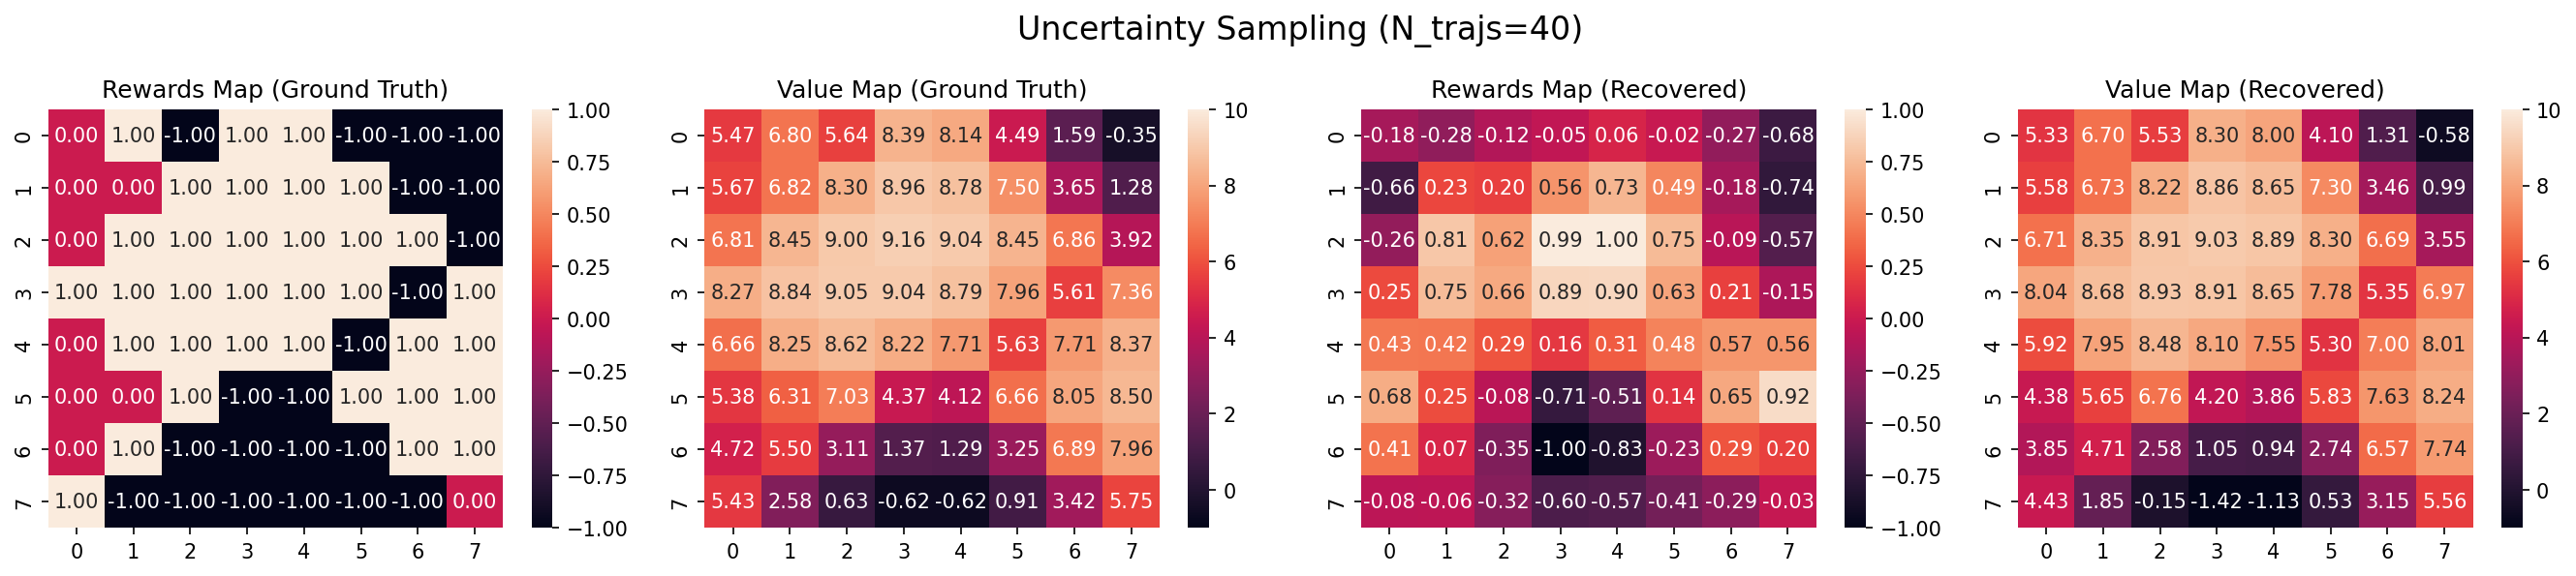

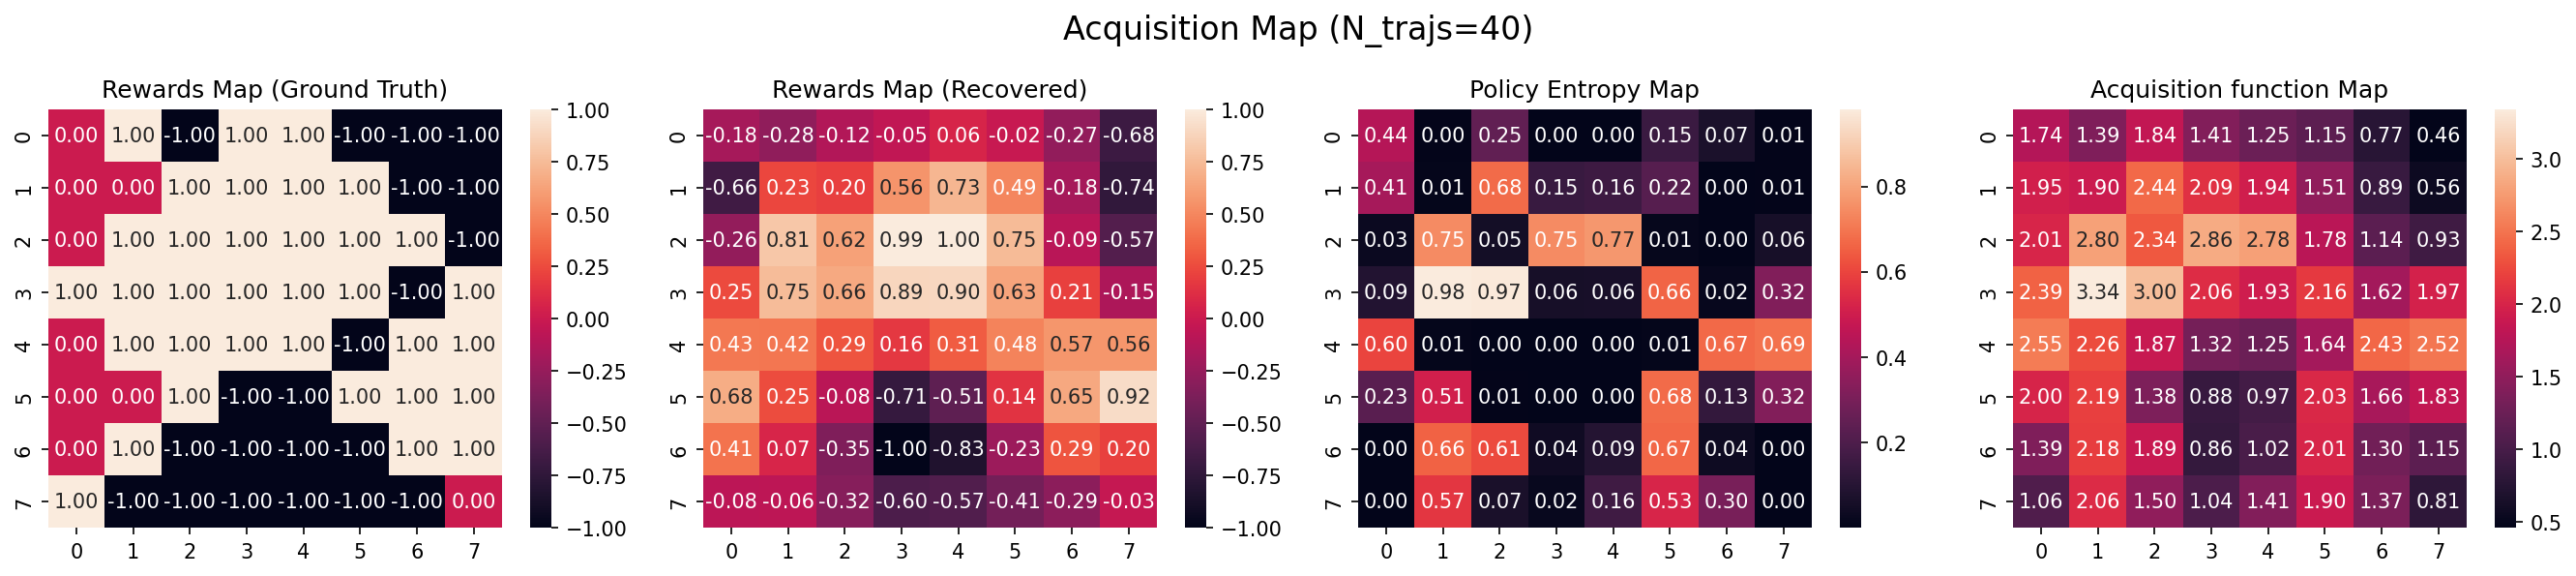

In [3]:
visualizer = Visualizer(history_deepmaxent_active, file_path=None, figsize=(18, 4), dpi=150)
n_trajs = 40
visualizer.draw_value_maps(search_idx=n_trajs)
visualizer.draw_acq_maps(search_idx=n_trajs)

In [ ]:
visualizer.objectworld_reward_policy(search_idx=n_trajs)

In [91]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2
import numpy as np

from src.GridWorldMDP.objectworld_utils import draw_path, generate_demonstrations, init_object_world, visitation_frequency
from src.deepmaxent_irl_objectworld import run_deepmaxent_irl
from src.maxent_irl_objectworld import run_maxent_irl
from src.img_utils import Visualizer, get_evd, draw_evd
from src.argument_parser import get_parser, parse_args_str

PARSER = get_parser()

DEEP_MAXENT_ACTIVE_ARGS = """
--exp_name deepmaxent_active
--type object
--n_objects 16
--n_colours 2
--height 8
--width 8
--gamma 0.9
--act_random 0.3
--n_trajs 10
--l_traj 8
--learning_rate 0.0001
--n_iters 30
--alpha 0.1
--n_query 1
--r_max 1
--error 0.01
--grad_clip 0.5
--weight_decay 0.01
--hiddens 32 32 16 8
--device cuda
--active
--seed 3
--verbose 2
--architecture cnn
"""

# becareful of learning rate will cause nan
args = parse_args_str(PARSER, DEEP_MAXENT_ACTIVE_ARGS)
print(args.exp_name)
history_deepmaxent_active = run_deepmaxent_irl(args, init_start_pos=None)

deepmaxent_active
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
[INFO] Initialize trajectories
Visitation Frequency
[[2 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 2 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
[INFO - n_trajs:1] Training Deep MaxEnt IRL
DeepIRLCNN(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.25, inplace=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.25, inplace=False)
    )
    (2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.25, inplace=False)
    )
    (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
    (4): Sequential(
     

  0%|          | 0/30 [00:00<?, ?it/s]

0


TypeError: conv2d() received an invalid combination of arguments - got (Sequential, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!Sequential!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!Sequential!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)


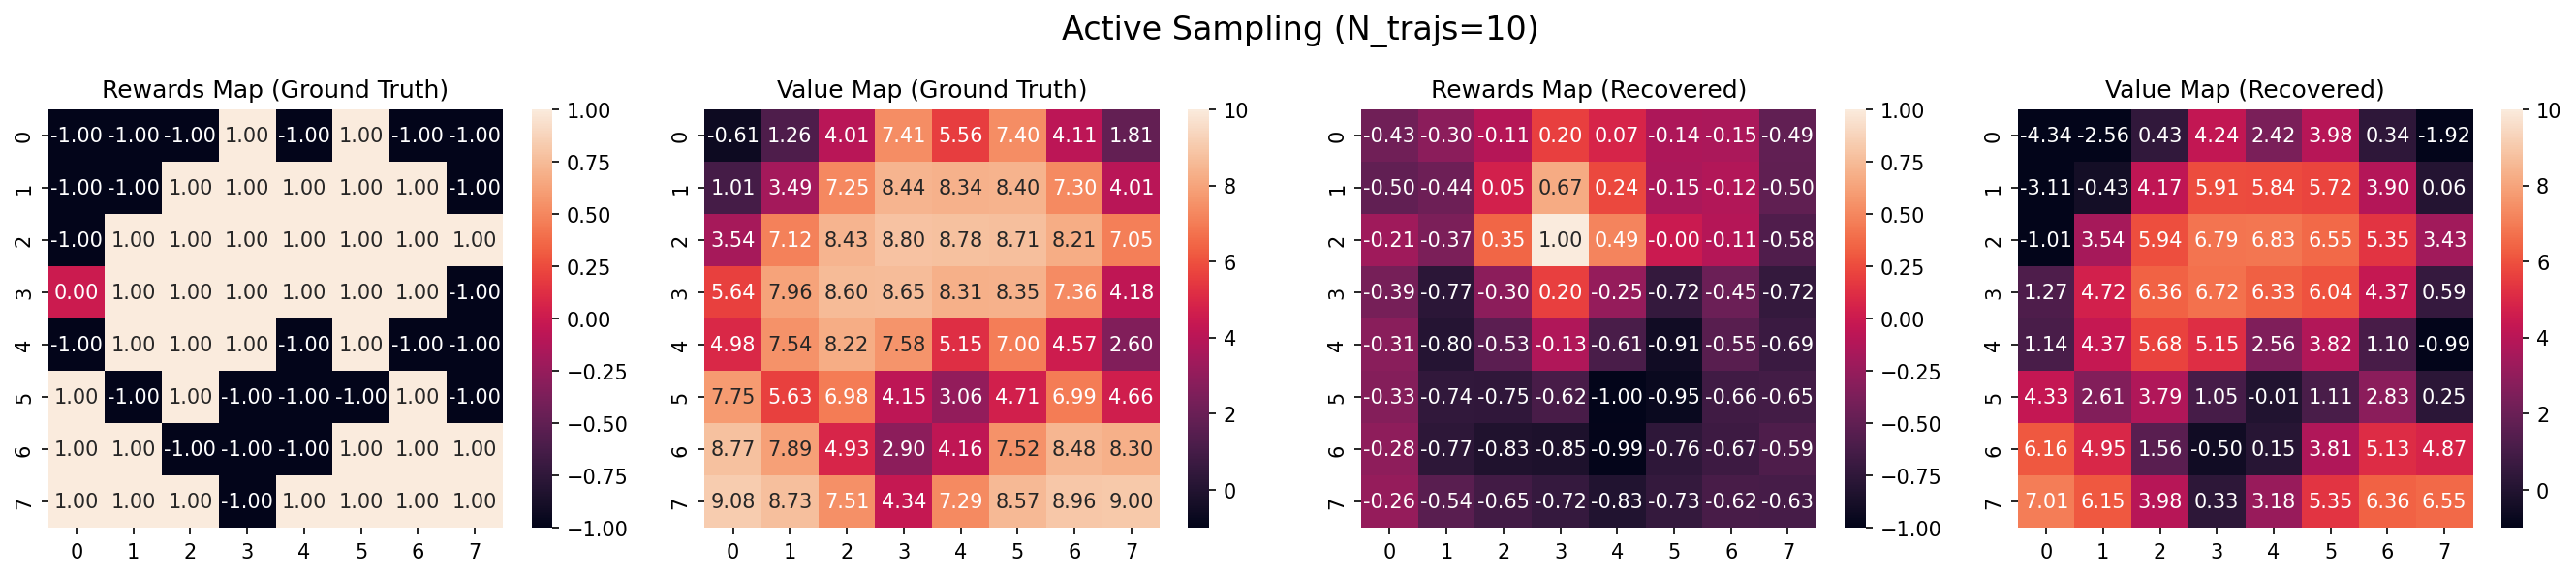

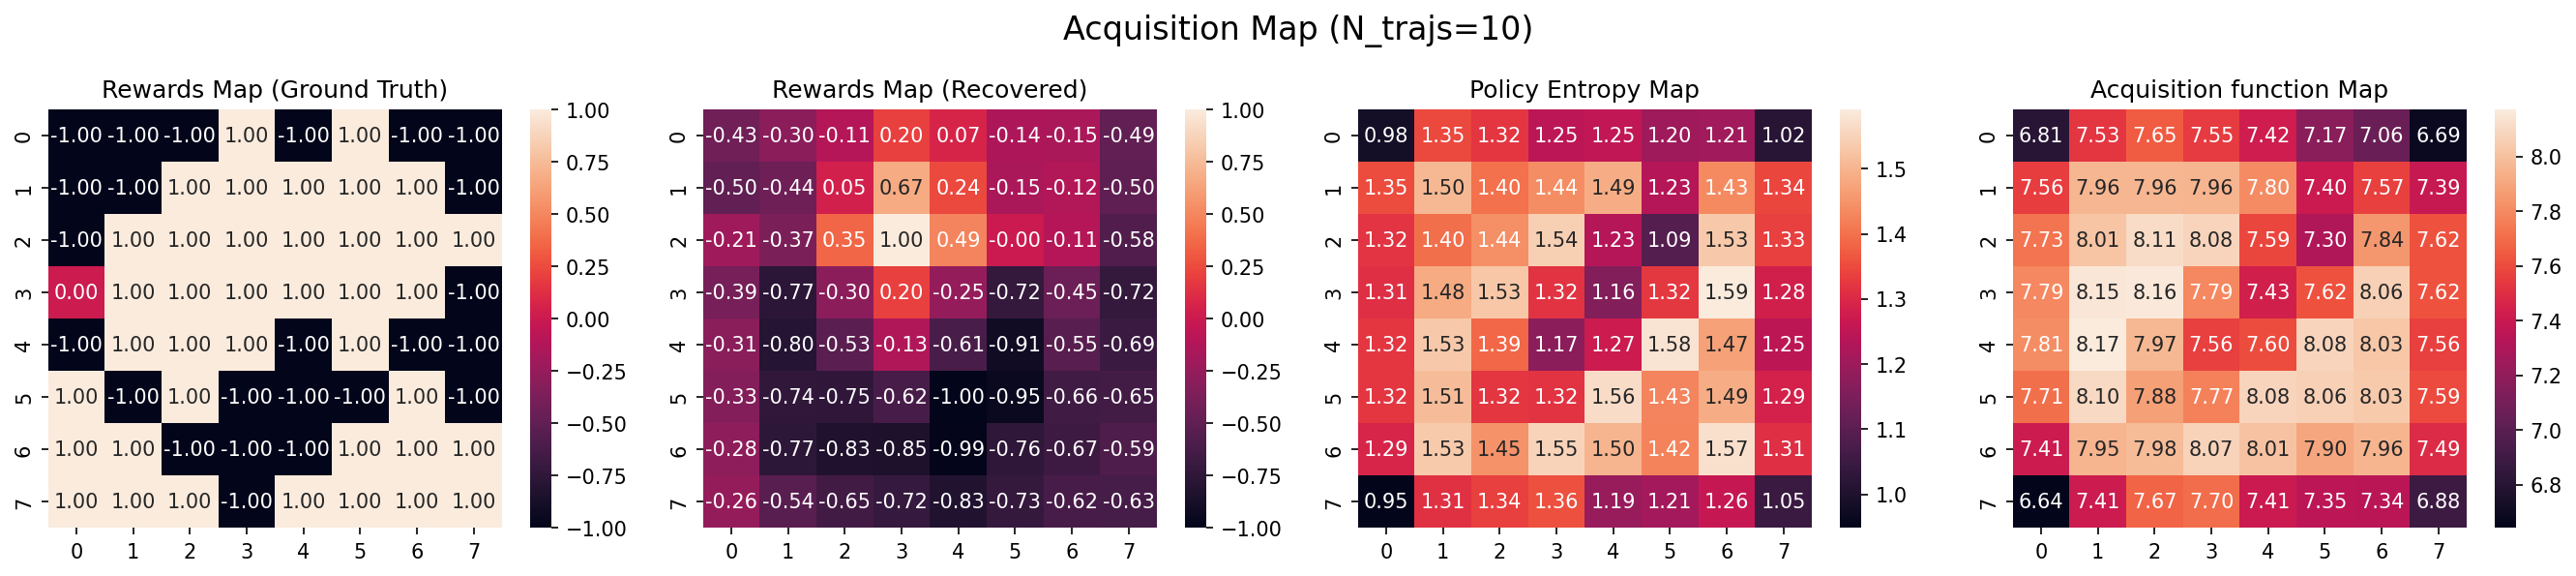

In [55]:
visualizer = Visualizer(history_deepmaxent_active, file_path=None, figsize=(18, 4), dpi=150)
n_trajs = 10
visualizer.draw_value_maps(search_idx=n_trajs)
visualizer.draw_acq_maps(search_idx=n_trajs)